#Import the neccessary supporting files

In [ ]:
!wget https://til-ai.sbs/male.jpeg
!wget https://til-ai.sbs/man2.png
!wget https://til-ai.sbs/woman.jpeg
!wget https://til-ai.sbs/woman2.png

#Start of the class

This code is an implementation of a Siamese Network for learning a similarity metric between pairs of images. The code can be broken down into the following sections:

- Import required libraries and modules.
- Define the Siamese Network architecture.
- Define a custom dataset for Siamese Network input.
- Define the Contrastive Loss function.
- Create a synthetic dataset of simple shapes.
- Initialize the dataset, dataloader, model, loss function, and optimizer.
- Train the Siamese Network.
- Plot the loss per batch.
- Test the Siamese Network


In [ ]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from pathlib import Path
from PIL import Image,  ImageDraw
import matplotlib.pyplot as plt

In [ ]:
# Siamese Network definition
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.AdaptiveAvgPool2d((10, 10))  # Add this line
        )
        self.fc = nn.Linear(10 * 10 * 64, 4096)
        
    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

In [ ]:
# Siamese Dataset class
class SiameseDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.dataset = ImageFolder(root)
        self.labels = np.unique(self.dataset.targets)
        self.label_to_indices = {label: np.where(np.array(self.dataset.targets) == label)[0]
                                 for label in self.labels}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img1, label1 = self.dataset[index]
        same_class = np.random.randint(0, 2)
        if same_class:
            siamese_label = 1
            index2 = np.random.choice(self.label_to_indices[label1])
        else:
            siamese_label = 0
            label2 = np.random.choice(np.delete(self.labels, label1))
            index2 = np.random.choice(self.label_to_indices[label2])

        img2, _ = self.dataset[index2]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(siamese_label, dtype=torch.float32)


In [ ]:
# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [ ]:
def create_synthetic_dataset(path, num_images=50, img_size=(100, 100)):
    Path(path).mkdir(parents=True, exist_ok=True)
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    shapes = ['circle', 'rectangle', 'triangle', 'ellipse', 'pentagon']

    for label, shape in enumerate(shapes):
        class_path = os.path.join(path, str(label))
        Path(class_path).mkdir(parents=True, exist_ok=True)
        for i in range(num_images):
            img = Image.new('RGB', img_size, 'white')
            draw = ImageDraw.Draw(img)
            color = random.choice(colors)
            x1, y1, x2, y2 = random.randint(10, 30), random.randint(10, 30), random.randint(60, 80), random.randint(60, 80)
            angle = random.randint(0, 360)

            # Create the shape
            temp_img = Image.new('RGBA', img_size)
            temp_draw = ImageDraw.Draw(temp_img)
            if shape == 'circle':
                temp_draw.ellipse((x1, y1, x2, y2), fill=color)
            elif shape == 'rectangle':
                temp_draw.rectangle((x1, y1, x2, y2), fill=color)
            elif shape == 'triangle':
                temp_draw.polygon([(x1, y1), (x2, y1), ((x1 + x2) // 2, y2)], fill=color)
            elif shape == 'ellipse':
                temp_draw.ellipse((x1, y1, x2, y2), fill=color)
            elif shape == 'pentagon':
                temp_draw.polygon([(x1, y1), (x2, y1), (x2 + (x1 - x2) // 4, (3 * y2 - y1) // 2),
                                   ((x1 + x2) // 2, y2), (x1 - (x2 - x1) // 4, (3 * y2 - y1) // 2)], fill=color)

            # Rotate the shape
            rotated_img = temp_img.rotate(angle, resample=Image.BICUBIC, expand=False)
            img.paste(rotated_img, (0, 0), rotated_img)

            img_path = os.path.join(class_path, f"{i}.png")
            img.save(img_path)

# Create synthetic dataset
dataset_path = "synthetic_data"
create_synthetic_dataset(dataset_path)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset and dataloader
root = dataset_path
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = SiameseDataset(root, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize the Siamese Network, loss function, and optimizer
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

num_epochs = 20
losses_per_batch = []

Epoch [1/20], Loss: 727.9462
Epoch [2/20], Loss: 471.6889
Epoch [3/20], Loss: 315.4959
Epoch [4/20], Loss: 262.8535
Epoch [5/20], Loss: 222.6873
Epoch [6/20], Loss: 164.3012
Epoch [7/20], Loss: 165.5394
Epoch [8/20], Loss: 130.7338
Epoch [9/20], Loss: 121.8413
Epoch [10/20], Loss: 100.9468
Epoch [11/20], Loss: 95.7917
Epoch [12/20], Loss: 76.8828
Epoch [13/20], Loss: 73.6315
Epoch [14/20], Loss: 63.8967
Epoch [15/20], Loss: 61.0795
Epoch [16/20], Loss: 47.5606
Epoch [17/20], Loss: 42.9364
Epoch [18/20], Loss: 46.8611
Epoch [19/20], Loss: 43.6111
Epoch [20/20], Loss: 38.0143


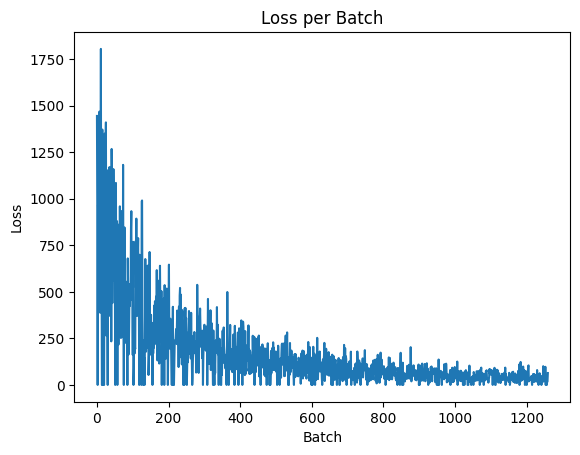

In [ ]:
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    for batch_idx, (img1, img2, label) in enumerate(dataloader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1
        losses_per_batch.append(loss.item())

    epoch_avg_loss = epoch_loss / num_batches
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_avg_loss:.4f}")

# Plot the losses per batch
plt.plot(losses_per_batch)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.show()


In [ ]:
# Create a synthetic test dataset
test_dataset_path = "synthetic_test_data"
create_synthetic_dataset(test_dataset_path, num_images=20)  # 20 images per class

# Define the test dataset and dataloader
test_dataset = SiameseDataset(test_dataset_path, transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test the model and compute accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for img1, img2, label in test_dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = model(img1, img2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        predictions = (euclidean_distance < 1).float()
        correct += (predictions == label).sum().item()
        total += label.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 53.00%
